# Predicting Readmission in Hospital Patients 

#### Analysis Conducted by Jared Murphy

## Introduction

Patient recidivism in hospitals can present a high expense.  If likely readmission could be detected early, medical staff can take the necessary measures to prevent a patient from needing to be readmitted to inpatient care.  While inpatient care can be quite expensive, outpatient care can be quite cheap in comparison.  It is in the best interest of a hospital to minimize patient early recidivism rate as much as possible so they can stay within budget and allocate precious resources most effectively.  To do this, a model that can accurately predict if a patient is likely to be readmitted in under 30 days would be most helpful.  This analysis attempts to create that model based on the UCI dataset found here    https://archive-beta.ics.uci.edu/ml/datasets/diabetes+130+us+hospitals+for+years+1999+2008  

## Preprocessing and EDA

### Feature Reduction

The papers used to inform the elimination of columns were "Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records" by Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clorefound found at https://downloads.hindawi.com/journals/bmri/2014/781670.pdf and "Risk factors associated with 30-day readmission and length of stay in patients with type 2 diabetes" by Laura M.Enomotoa, Deepika P.Shresthaa, Meredith B.Rosenthalb, Christopher S.Hollenbeaka, and Robert A.Gabbay found at  https://www.sciencedirect.com/science/article/abs/pii/S1056872716307383.

#### Overview of Support from "Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records"

Cut weight and payer code.  Paper finds gender to not be statistically significant so cut that as well.  Remove all encounters involving discharge to hospice or death. HbA1C measure is more useful being treated as a binary variable focusing on whether the test was administered at all rather than the results of the test.  

In [1]:
#Import packages 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import training data and delete weight, payer code, and gender
df=pd.read_csv("diabetic_data_train.csv").drop(columns=['weight','gender','payer_code'])

#import and sort id_codes for admssion type, discharge disposition, and admission source 

dfid=pd.read_csv("IDs_mapping.csv")
df_admissionTypeID = dfid.iloc[0:8]
df_dischargeID=dfid.iloc[10:40].reset_index(drop=True)
df_dischargeID.columns=['discharge_disposition_id', "description"]
df_dischargeID.dropna(inplace=True)
df_admissionSourceID=dfid.iloc[42:].reset_index(drop=True)
df_admissionSourceID.columns=['admission_source_id', "description"]

#remove all encounters occurring in discharge to hospice or death

def hospiceDeathFilter(df_dischargeID):
    """This function was used to find the codes which refer to hospice and death
    so that they may be eliminated"""
    hospice=df_dischargeID['description'].str.contains('hospice')
    Hospice=df_dischargeID['description'].str.contains('Hospice')
    expired=df_dischargeID['description'].str.contains('expired')
    Expired=df_dischargeID['description'].str.contains('Expired')
    death_array=[]
    hospiceArr=df_dischargeID[hospice].discharge_disposition_id.to_numpy()
    for i in range(len(hospiceArr)):
        death_array.append(hospiceArr[i])
    HospiceArr=df_dischargeID[Hospice].discharge_disposition_id.to_numpy()
    for i in range(len(HospiceArr)):
        death_array.append(HospiceArr[i])
    expiredArr=df_dischargeID[expired].discharge_disposition_id.to_numpy()
    for i in range(len(expiredArr)):
        death_array.append(expiredArr[i])
    ExpiredArr=df_dischargeID[Expired].discharge_disposition_id.to_numpy()
    for i in range(len(ExpiredArr)):
        death_array.append(ExpiredArr[i])
    return np.unique(np.array(death_array))

#The results show that discharge codes 11,13,14,19,20,21 contain references to death 
#and hospice
df=df[df['discharge_disposition_id'] != 11]
df=df[df['discharge_disposition_id'] != 13]
df=df[df['discharge_disposition_id'] != 14]
df=df[df['discharge_disposition_id'] != 19]
df=df[df['discharge_disposition_id'] != 20]
df=df[df['discharge_disposition_id'] != 21]

#now change HbA1C into a binary variable 1 = received testing, 0 = did not receive testing

df['A1Cresult'] = df['A1Cresult'].replace({'None':0, '>8':1,'Norm':1, '>7': 1})

##### Dealing with dimensionality of diag_1, diag_2, diag_3

One hot encoding these columns would lead to an outrageous number of features, and because the researchers encoded the diagnoses in a shorthand form, even comparing it to the actual ICD-9-CM is not straightforward and may be more work than its worth.  The ICD-9 labels can be found here https://www.cms.gov/Medicare/Coding/ICD9ProviderDiagnosticCodes/codes.  Because of this, working with these features we be strictly time permitting.  For now, we will have to drop the columns due to complexity issues.

In [2]:
#drop the three diagnosis columns 
df=df.drop(columns=['diag_1','diag_2','diag_3'])

#### Overview of Support from "Risk factors associated with 30-day readmission and length of stay in patients with type 2 diabetes"

There is no call from the second paper to drop any other data, but some adjustments can be made.  The second paper postulates that Gender, Race, Hospital Transfer, Urgent or Emergency Admission, Comorbidities such as circulatory disease, infectious complications, heart/raspatory failure, glucose levels, hemoglobin, A1C measurements, insulin usage and duration of diabetic illness are all possible significant contributors to readmission.

##### Dealing with dimensionality of admission_type_id, discharge_disposition_id, and adission_source_id

As can be seen in the ID's mapping data, we have a massive amount of dimensionality due to the many nominal classes found in the admission and discharge descriptions.  The second paper emphasizes Hospital Transfer as well as Urgent or Emergency admission as being significant predictors of patient readmission.  We will use this information to further reduce dimensionality.  Regarding hospital transfers: after eliminating the patients with death or hospice descriptions from the discharge disposition table, we are left with many features involving discharge/transfers.  Let us collapse into a single class all the ID's that involve transfers.  We will keep "Discharged to Home", "Left AMA", "Admitted as an inpatient to this hospital", and "Still patient or expected to return for outpatient" as their own separate categories, and we will group the Not Mapped and Unknown/Invalid into a single category.  Regarding Admission Types:  This field will be collapsed into two categories, one containing both descriptions of "Emergency" and "Urgent", and another containing everything else.  Regarding admission sources: All descriptions containing "transfers" will be collapsed into one field, all descriptions regarding referrals will be collapsed into another, and all missing or unmapped values will be collapsed as well.  The rest will go untouched.   

In [3]:
#replacing all discharge_disposition_id's involving transfers with the same nominal variable
for i in range(2,7):
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace({i:2})
for i in [8,10,15,16,17,22,23,24,30,27,28,29]:
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace({i:2})
#replacing the missing and unmapped discharge_disposition_id's with same nominal variable
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace({25:3,26:3})

#binning the admission_type_id column into two categories
for i in [1,2]:
    df["admission_type_id"] = df["admission_type_id"].replace({i:1})
for i in [3,4,5,6,7,8]:
    df["admission_type_id"] = df["admission_type_id"].replace({i:2})
    
#collapsing admission_source_id
for i in [1,2,3]:
    df["admission_source_id"] = df["admission_source_id"].replace({i:1})
for i in [4,5,6,10,18,22,25,26]:
    df["admission_source_id"] = df["admission_source_id"].replace({i:2})
for i in [9,15,17,20,21]:
    df["admission_source_id"] = df["admission_source_id"].replace({i:3})

#### Personal Choices for Feature Changes

We will cut medical_specialty because nearly half of the values are missing, and we don’t think that a binary present/absent of the record itself would be particularly useful. We will eliminate all specific medication features because most of the information we care about is contained in the diabetesMed feature, which states whether they were prescribed any form of diabetes medication. Encounter ID and patient number will be deleted as they are just numeric identifiers. Now going through each left-over feature one by one. The Race “?” symbol will be replaced by "Unknown" and the variable will be one-hot encoded for modeling. We shall 1 hot encode age, admission_type_id, discharge_disposition_id, admission_source_id. For now we will discard the 3 diagnosis columns because using them will expand our dimensionality dramatically, but these features will be revisited because there is surely some useful information there. We will change the max_glu_serum test to 0 for no test administered and 1 for test administered with no regard for the results. change the “ch” value in change variable to yes and 1 hot encode. Finally, we will change the readmitted feature to 0 if not readmitted or readmitted after 30 days, and 1 if readmitted before 30 days. 

In [4]:
#Cut medical_specialty
df=df.drop(columns=['Unnamed: 0', 'medical_specialty'])
#drop all specific medication features
df=df.drop(columns=['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone'])
#drop encounter id and patient number 
df=df.drop(columns=['encounter_id','patient_nbr'])
#change race ? to Unknown and 1 hot encode listed variables
df['race'] = df['race'].replace({'?':"Unknown"})
df=pd.get_dummies(df,columns=['race','age','admission_type_id','discharge_disposition_id','admission_source_id'])
#change the max_glu_serum column to 0 1
df['max_glu_serum'] = df['max_glu_serum'].replace({'None':0,'Norm':1, '>200':1, '>300':1})
#change the change variable value ch to yes and 1 hot encode along with diabetesMed
df['change'] = df['change'].replace({'Ch':'Yes'})
df=pd.get_dummies(df,columns=['change','diabetesMed'])
#Change readmitted to 0 1
df['readmitted'] = df['readmitted'].replace({'NO':0,'>30':0, '<30':1})

In [5]:
#Check for null values
df.isnull().sum().sum()

0

### Correlations

Let us now create a correlation map to see if there is any redundancy within the numerical data.  We will look at a heat map comparing time_in_hospital, num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient, and number_diagnosis.  All these features are numerical in nature. 

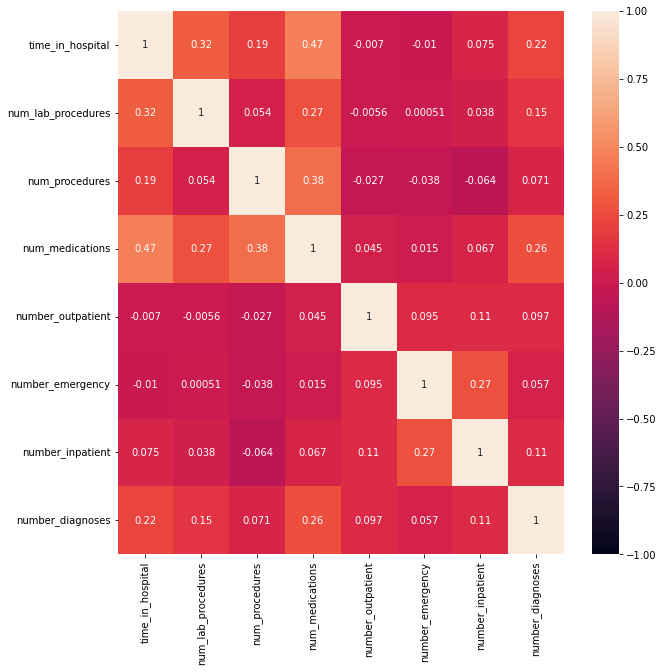

In [6]:
df_numerical=df[['time_in_hospital', 'num_lab_procedures', 'num_procedures',
            'num_medications', 'number_outpatient', 'number_emergency',
            'number_inpatient', 'number_diagnoses']]
plt.rcParams["figure.figsize"] = (10,10)
sns.heatmap(df_numerical.corr(),vmin=-1,vmax=1,annot=True)
plt.show()

There does not appear to be any markedly high correlations between any of the variables listed.  The maximum correlation of 0.47 is between the features time_in_hospital and num_medications, but the correlation is not high enough to indicate redundancy.  

### Scaling

For the final preprocessing step we will scale the numerical features listed above using sklearn Standard Scaler, which removes the mean from the feature and scales to its unit variance.   

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
#we will use the ColumnTransformer class to scale the numerical features
column_names=list(df.columns)
features=['time_in_hospital', 'num_lab_procedures', 'num_procedures',
            'num_medications', 'number_outpatient', 'number_emergency',
            'number_inpatient', 'number_diagnoses']
data=df[df.columns]
ct = ColumnTransformer([
        ('somename', StandardScaler(), features)
    ], remainder='passthrough')
df=pd.DataFrame(ct.fit_transform(data),columns=column_names)
#now reassign categorical columns back to integers
int_column_list=['max_glu_serum', 'A1Cresult', 'readmitted', 'race_AfricanAmerican',
       'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other',
       'race_Unknown', 'age_[0-10)', 'age_[10-20)', 'age_[20-30)',
       'age_[30-40)', 'age_[40-50)', 'age_[50-60)', 'age_[60-70)',
       'age_[70-80)', 'age_[80-90)', 'age_[90-100)', 'admission_type_id_1',
       'admission_type_id_2', 'discharge_disposition_id_1',
       'discharge_disposition_id_2', 'discharge_disposition_id_3',
       'discharge_disposition_id_7', 'discharge_disposition_id_9',
       'discharge_disposition_id_12', 'discharge_disposition_id_18',
       'admission_source_id_1', 'admission_source_id_2',
       'admission_source_id_3', 'admission_source_id_7',
       'admission_source_id_8', 'admission_source_id_11',
       'admission_source_id_13', 'admission_source_id_14', 'change_No',
       'change_Yes', 'diabetesMed_No', 'diabetesMed_Yes']
#some null values arose in the concatonation, there are few so lets drop them
df=df.dropna()
for column in int_column_list:
    df[column]=df[column].astype(int)

### Preprocessing Pipeline

Now let’s create a single function that does all of the above tasks so that we can easily preprocess new data for predictions.

In [8]:
def preprocess(df,dfid):
    
    """This function runs new data through a preprocess so that it can run through our classifier
    for predictions WARNING!!! Must have the id dataframe available for preprocessing.  If data is
    introduced to this preprocess that involves either hospice or death, that data will be discarded
    and us considered erronious.  Any patient who has died or is on their way to hospice can be assumed
    to be guarenteed to not be readmitted, and should therefore not be considered for modeling"""
    
    df=df.drop(columns=['weight','gender','payer_code'])
    
    #import and sort id_codes for admssion type, discharge disposition, and admission source 
    dfid=pd.read_csv("IDs_mapping.csv")
    df_admissionTypeID = dfid.iloc[0:8]
    df_dischargeID=dfid.iloc[10:40].reset_index(drop=True)
    df_dischargeID.columns=['discharge_disposition_id', "description"]
    df_dischargeID.dropna(inplace=True)
    df_admissionSourceID=dfid.iloc[42:].reset_index(drop=True)
    df_admissionSourceID.columns=['admission_source_id', "description"]
    
    #remove all encounters occurring in discharge to hospice or death
    df=df[df['discharge_disposition_id'] != 11]
    df=df[df['discharge_disposition_id'] != 13]
    df=df[df['discharge_disposition_id'] != 14]
    df=df[df['discharge_disposition_id'] != 19]
    df=df[df['discharge_disposition_id'] != 20]
    df=df[df['discharge_disposition_id'] != 21]
    
    #now change HbA1C into a binary variable 1 = received testing, 0 = did not receive testing
    df['A1Cresult'] = df['A1Cresult'].replace({'None':0, '>8':1,'Norm':1, '>7': 1})
    
    #drop the three diagnosis columns 
    df=df.drop(columns=['diag_1','diag_2','diag_3'])
    
    #replacing all discharge_disposition_id's involving transfers with the same nominal variable
    for i in range(2,7):
        df['discharge_disposition_id'] = df['discharge_disposition_id'].replace({i:2})
    for i in [8,10,15,16,17,22,23,24,30,27,28,29]:
        df['discharge_disposition_id'] = df['discharge_disposition_id'].replace({i:2})
    
    #replacing the missing and unmapped discharge_disposition_id's with same nominal variable
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace({25:3,26:3})

    #binning the admission_type_id column into two categories
    for i in [1,2]:
        df["admission_type_id"] = df["admission_type_id"].replace({i:1})
    for i in [3,4,5,6,7,8]:
        df["admission_type_id"] = df["admission_type_id"].replace({i:2})
    
    #collapsing admission_source_id
    for i in [1,2,3]:
        df["admission_source_id"] = df["admission_source_id"].replace({i:1})
    for i in [4,5,6,10,18,22,25,26]:
        df["admission_source_id"] = df["admission_source_id"].replace({i:2})
    for i in [9,15,17,20,21]:
        df["admission_source_id"] = df["admission_source_id"].replace({i:3})
    
    #Cut medical_specialty
    df=df.drop(columns=['Unnamed: 0', 'medical_specialty'])
    
    #drop all specific medication features
    df=df.drop(columns=['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone'])
    
    #drop encounter id and patient number 
    df=df.drop(columns=['encounter_id','patient_nbr'])
    
    #change race ? to Unknown and 1 hot encode listed variables
    df['race'] = df['race'].replace({'?':"Unknown"})
    df=pd.get_dummies(df,columns=['race','age','admission_type_id','discharge_disposition_id','admission_source_id'])
    
    #change the max_glu_serum column to 0 1
    df['max_glu_serum'] = df['max_glu_serum'].replace({'None':0,'Norm':1, '>200':1, '>300':1})
    
    #change the change variable value ch to yes and 1 hot encode along with diabetesMed
    df['change'] = df['change'].replace({'Ch':'Yes'})
    df=pd.get_dummies(df,columns=['change','diabetesMed'])
    
    #Change readmitted to 0 1
    df['readmitted'] = df['readmitted'].replace({'NO':0,'>30':0, '<30':1})
    
    from sklearn.preprocessing import StandardScaler
    from sklearn.compose import ColumnTransformer
    #we will use the ColumnTransformer class to scale the numerical features
    column_names=list(df.columns)
    features=['time_in_hospital', 'num_lab_procedures', 'num_procedures',
            'num_medications', 'number_outpatient', 'number_emergency',
            'number_inpatient', 'number_diagnoses']
    data=df[df.columns]
    ct = ColumnTransformer([('somename', StandardScaler(), features)], remainder='passthrough')
    df=pd.DataFrame(ct.fit_transform(data),columns=column_names)
    return df

## Model Selection

Below we will train several classifiers on the data and use recall, also called True Positive Rate, as our primary metric for evaluation.  The reason for this is that we care more about minimizing false negatives in the context of predicting readmission.  From a public health standpoint, it is much better for a patient to be labeled likely for readmission while not actually being readmitted rather than a patient being labeled unlikely for readmission while being readmitted in under 30 days.  And from a business perspective, given that inpatient care is often vastly more expensive than outpatient, it is more important to accurately predict the likelihood of incurring the high cost of readmission, even if you end up being over constrained in your budget.  We will also look at ROC curves and take their AUC into account.  For all model evaluations 5-fold cross validation will be performed as well as a grid search for optimal hyperparameters.          

In [9]:
#import packages
import warnings 
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

#Divide data into X for predictor and y for response/labels
X=df.drop(columns='readmitted')
y=df['readmitted']

## Random Forest

n_estimators: 1
criterion: gini
max_depth: None
Recall: 0.16378263362733092
n_estimators: 1
criterion: entropy
max_depth: None
Recall: 0.146217732124525
n_estimators: 2
criterion: gini
max_depth: None
Recall: 0.03373700989400981
n_estimators: 2
criterion: entropy
max_depth: None
Recall: 0.03650983352262459
n_estimators: 3
criterion: gini
max_depth: None
Recall: 0.08307535498990608
n_estimators: 3
criterion: entropy
max_depth: None
Recall: 0.07965372424185586
n_estimators: 4
criterion: gini
max_depth: None
Recall: 0.029637271059202126
n_estimators: 4
criterion: entropy
max_depth: None
Recall: 0.02655459542860425
n_estimators: 5
criterion: gini
max_depth: None
Recall: 0.05689630709594801
n_estimators: 5
criterion: entropy
max_depth: None
Recall: 0.05334132193694406
n_estimators: 6
criterion: gini
max_depth: None
Recall: 0.02710614492461031
n_estimators: 6
criterion: entropy
max_depth: None
Recall: 0.02447626965822703
n_estimators: 7
criterion: gini
max_depth: None
Recall: 0.0410279866687

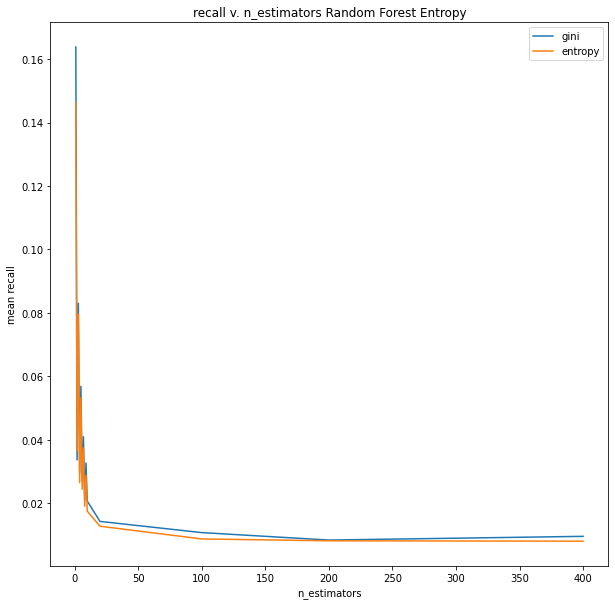

In [10]:
#import model
from sklearn.ensemble import RandomForestClassifier
#list hyperparameters for gridsearch
n_est=[1,2,3,4,5,6,7,8,9,10,20,100,200,400]
c=['gini','entropy']
m_depth=[None]
mean_list_gini=[]
mean_list_entropy=[]
#create nested loops for grid search
for i in n_est:
    for j in c:
        for k in m_depth:
            #create model
            clf=RandomForestClassifier(n_estimators=i,criterion=j,max_depth=k)
            #start Kfold
            cv = KFold(n_splits=5, random_state=1, shuffle=True)
            # evaluate model
            scores = cross_val_score(clf, X.values, y.values, scoring='recall', cv=cv, n_jobs=-1)
            #report performance
            print("n_estimators: "+str(i))
            print("criterion: "+ j)
            print("max_depth: "+str(k))
            print('Recall: ' +str(np.mean(scores)))
            if (j=='gini'):
                mean_list_gini.append(np.mean(scores))
            if (j=='entropy'):
                mean_list_entropy.append(np.mean(scores))
plt.plot(n_est,mean_list_gini,label='gini')
plt.title('recall v. n_estimators Random Forest Gini')
plt.xlabel('n_estimators')
plt.ylabel('mean recall')
plt.plot(n_est,mean_list_entropy,label='entropy')
plt.title('recall v. n_estimators Random Forest Entropy')
plt.xlabel('n_estimators')
plt.ylabel('mean recall')
plt.legend(loc='upper right')
plt.show()

The Random Forest with largest recall is n_estimators = 1, criterion = gini and max_depth = None.  However, upon further testing, it appears that AUC increases as n_estimators gets larger and that a random forest with 1 estimator has an AUC of .5, therefore it has no class separation capacity whatsoever.  See the charts below.  

#### n_estimators = 1  

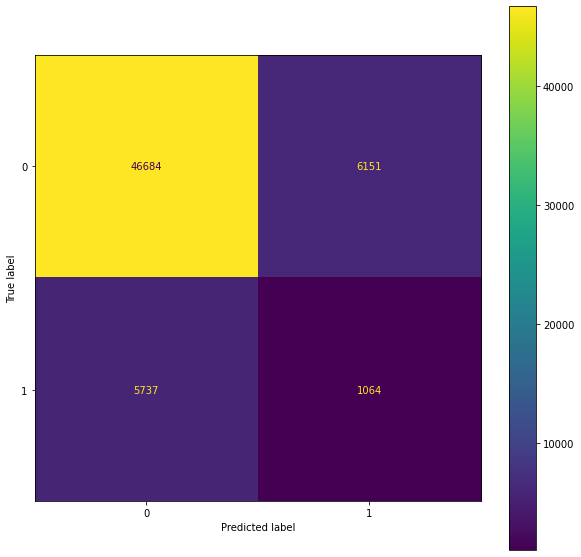

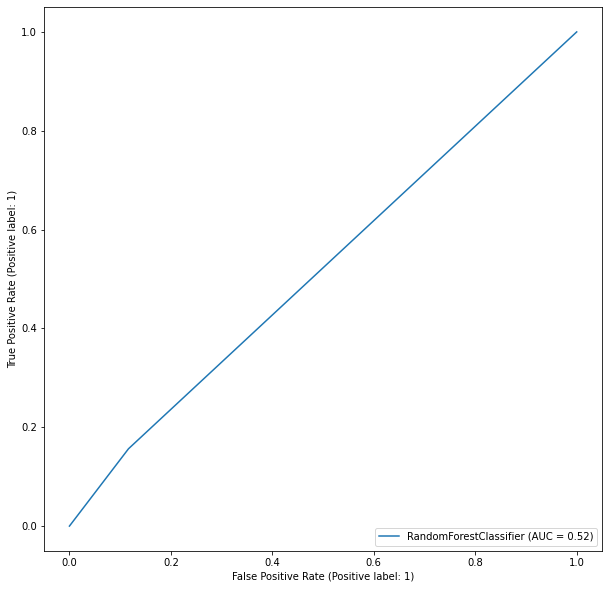

In [11]:
#divide data into training and validation
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.8,random_state=42)

#define and fit model
clf=RandomForestClassifier(n_estimators=1,criterion='gini',max_depth=None)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
y_true=y_test

#plot confusion matrix
warnings.filterwarnings(action='ignore', category=FutureWarning)
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

#plot roc curve with AUC listed
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.show()


#### n_estimators = 400

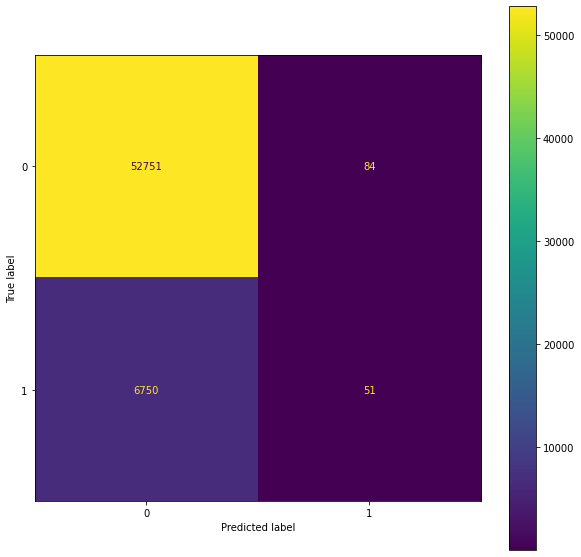

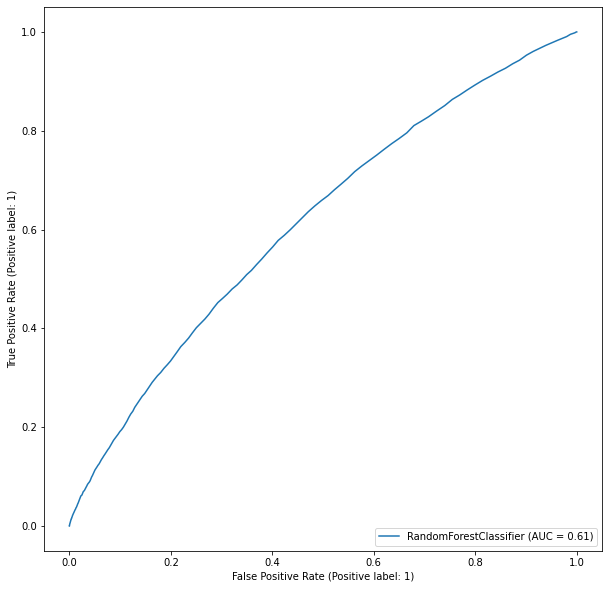

In [12]:
#divide data into training and validation
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.8,random_state=42)

#define and fit model
clf=RandomForestClassifier(n_estimators=400,criterion='gini',max_depth=None)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
y_true=y_test

#plot confusion matrix
warnings.filterwarnings(action='ignore', category=FutureWarning)
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

#plot roc curve with AUC listed
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.show()

With higher values of n_estimators, the AUC stabilizes at 0.54 which is still quite low, but the sacrifice in recall for increased AUC in the testing scenario could help the model generalize better.  Let’s see if we have better luck with other models below.      

## Logistic Regression

The same process as above will be applied using a Logistic Regression Classifier

In [13]:
#import model
from sklearn.linear_model import LogisticRegression
#list hyperparameters for gridsearch
#penalty_sag=['l2','none']
#penalty_saga=['elasticnet','l1','l2','none']
penalty_sag=['none']
penalty_saga=['l1']

#create nested loops for grid search
print('SAG')
for i in penalty_sag:
    #create model
    clf=LogisticRegression(penalty=i,solver='sag',max_iter=4000)
    #start Kfold
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    # evaluate model
    scores = cross_val_score(clf, X.values, y.values, scoring='recall', cv=cv, n_jobs=-1)
    # report performance
    print("solver: sag")
    print("penalty: "+ i)
    print('Recall: ' +str(np.mean(scores))) 
print('')
print('SAGA')
for i in penalty_saga:
    #create model
    clf=LogisticRegression(penalty=i,solver='saga',max_iter=4000)
    #start Kfold
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    # evaluate model
    scores = cross_val_score(clf, X.values, y.values, scoring='recall', cv=cv, n_jobs=-1)
    # report performance
    print("solver: sag")
    print("penalty: "+ i)
    print('Recall: ' +str(np.mean(scores))) 

SAG


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


solver: sag
penalty: none
Recall: 0.014035910544412958

SAGA
solver: sag
penalty: l1
Recall: 0.01403461626295715


Logistic Regression is repeatedly having convergence problems, and even after increasing the iterations to 4000 to get convergence the Recall is quite low.  Let’s move on and try K-Nearest Neighbor.

## KNN

In [14]:
#import model
from sklearn.neighbors import KNeighborsClassifier
#list hyperparameters for gridsearch
n_neigh=[1,2,3,4,5,6,7,8,9,10]
distance=['euclidean','minkowski']
mean_list_euclidean=[]
mean_list_minkowski=[]
#create nested loops for grid search
for i in n_neigh:
    for j in distance:
        #create model
        clf=KNeighborsClassifier(n_neighbors=i, metric=j)
        #start Kfold
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        # evaluate model
        scores = cross_val_score(clf, X.values, y.values, scoring='recall', cv=cv, n_jobs=-1)
        #report performance
        #print("n_estimators: "+str(i))
        #print("criterion: "+ j)
        #print("max_depth: "+str(k))
        #print('Recall: ' +str(np.mean(scores)))
        if (j=='euclidean'):
            mean_list_euclidean.append(np.mean(scores))
        if (j=='minkowski'):
            mean_list_minkowski.append(np.mean(scores))

print("Euclidean")
print(dict(zip(n_neigh,mean_list_euclidean)))
print("Minkowski")
print(dict(zip(n_neigh,mean_list_minkowski)))

Euclidean
{1: 0.15422482106095897, 2: 0.029122636343516334, 3: 0.07371978838905356, 4: 0.022388084031193908, 5: 0.042838723725832736, 6: 0.016722123657332104, 7: 0.02848951024176452, 8: 0.014963479706030286, 9: 0.021209134604008844, 10: 0.012374989065826639}
Minkowski
{1: 0.15422482106095897, 2: 0.029122636343516334, 3: 0.07371978838905356, 4: 0.022388084031193908, 5: 0.042838723725832736, 6: 0.016722123657332104, 7: 0.02848951024176452, 8: 0.014963479706030286, 9: 0.021209134604008844, 10: 0.012374989065826639}


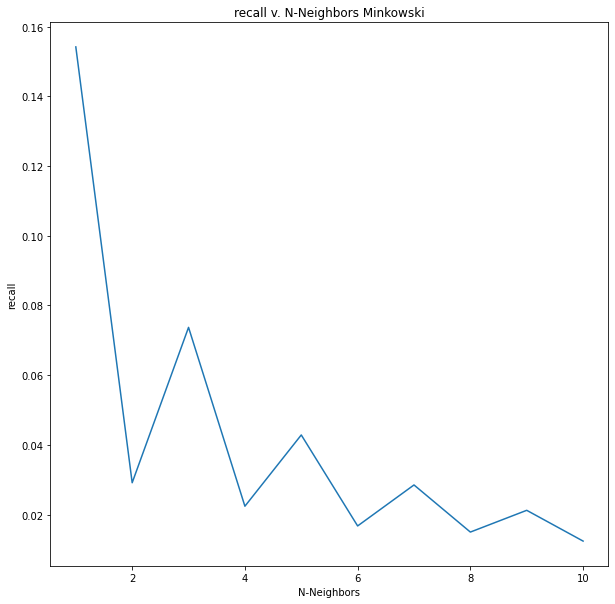

In [15]:
#plotting the recall v. N-Neighbors using Minkowski distance
plt.plot(n_neigh,mean_list_minkowski)
plt.title("recall v. N-Neighbors Minkowski")
plt.xlabel('N-Neighbors')
plt.ylabel('recall')
plt.show()

As we can see from the above chart, KNN N=1 provides the best recall.  Let's generate a confusion matrix and ROC cure to check the AOC.

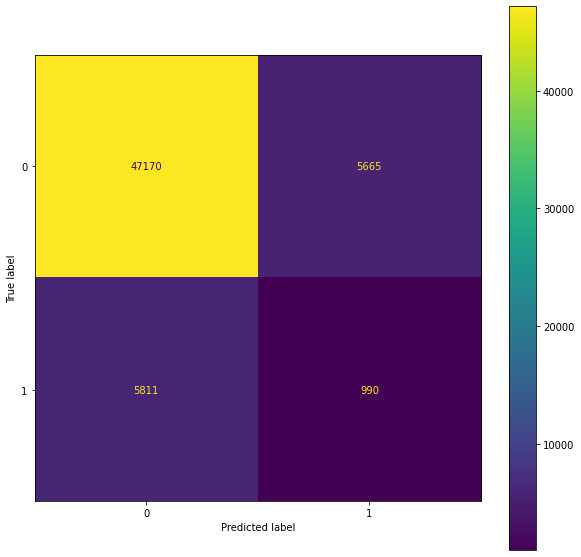

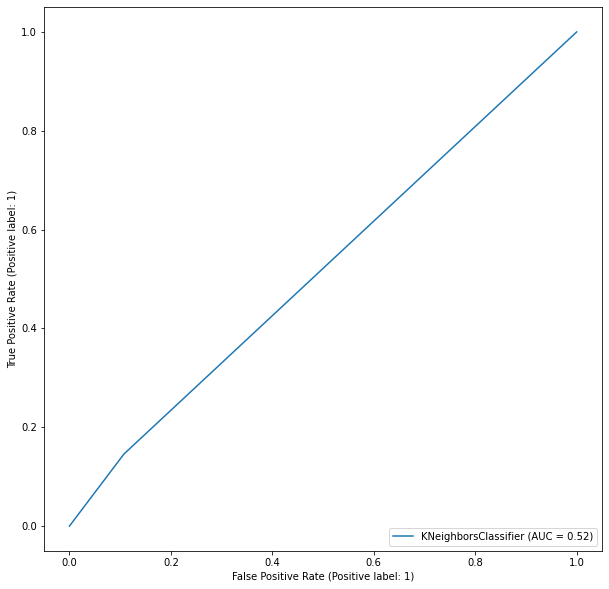

In [16]:
#divide data into training and validation
X_train,X_test,y_train,y_test=train_test_split(X.values,y.values,test_size=.8,random_state=42)

#define and fit model
clf=KNeighborsClassifier(n_neighbors=1,metric='minkowski')
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
y_true=y_test

#plot confusion matrix
warnings.filterwarnings(action='ignore', category=FutureWarning)
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

#plot roc curve with AUC listed
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.show()

Our AUC for KNN where N=1 is not much more than .5, and therefore does not carry much predictive power.  Out of all the models tested using both a grid search and 5-fold cross validation, the best performing was the Random Forest with n_estimators=400, criterion=gini, and max_depth=None.  Below we will evaluate this model on the test set and then provide concluding remarks. 

## Test Set Evaluation

Recall: 0.0021216407355021216
Precision: 0.5454545454545454
Accuracy: 0.8860034678817694
F1: 0.004226840436773511


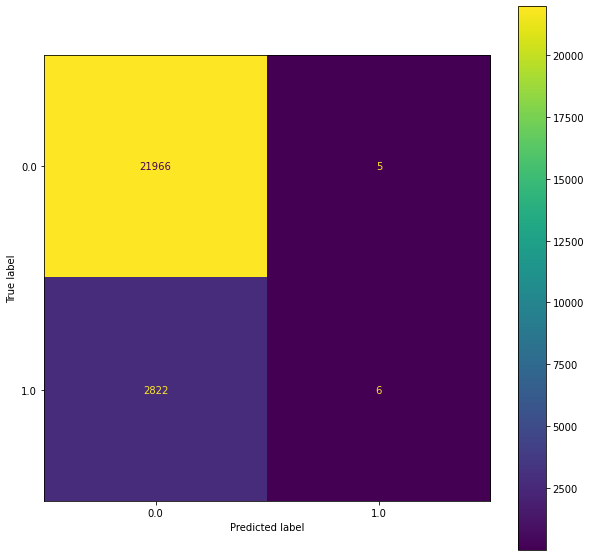

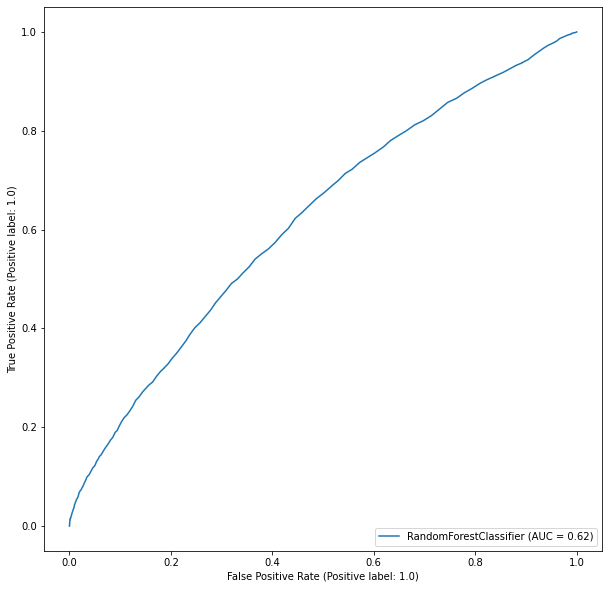

In [17]:
#import train data and run through preprocess
df_train=pd.read_csv("diabetic_data_train.csv")
df_idTrain=pd.read_csv("IDs_mapping.csv")
df_train=preprocess(df_train,df_idTrain)

#Train Random Forest on training data
X_train=df_train.drop(columns='readmitted').values
y_train=df_train['readmitted'].values
clf=RandomForestClassifier(n_estimators=400,criterion='gini',max_depth=None)
clf.fit(X_train, y_train)

#import test data and run through preprocess 
df_test=pd.read_csv("diabetic_data_test.csv")
df_idTest=pd.read_csv("IDs_mapping.csv")
df_test=preprocess(df_test,df_idTest)
#Add extra columns to allow model to process
df_test['discharge_disposition_id_12']=0
df_test['admission_source_id_11']=0
df_test['admission_source_id_13']=0
df_test['admission_source_id_14']=0
X_test=df_test.drop(columns='readmitted').values
y_test=df_test['readmitted'].values
#Use model trained with training data to make predictions using test
y_pred=clf.predict(X_test)

#print final model recall,precision,accuracy, and f1 score
from sklearn.metrics import recall_score, precision_score,accuracy_score,f1_score

recall=recall_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)
accuracy=accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)
print("Recall: " + str(recall))
print("Precision: " + str(precision))
print("Accuracy: " + str(accuracy))
print("F1: " + str(f1))

#plot confusion matrix
warnings.filterwarnings(action='ignore', category=FutureWarning)
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

#plot roc curve with AUC listed
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.show()

Our recall is quite low, but AUC is higher than earlier indicating that the model should have at least some ability to distinguish between classes in the wild.  Of course, more work needs to be done to increase performance.  For another day.  

## Conclusion

For this analysis we were provided with 10 year’s worth of clinical care data for diabetes patients.  With the help of past research, we reduced the number of features to a manageable number, and then evaluated several classifiers to find one that provided the best Recall (True Positive Rate) while predicting readmission.  Having performed a grid search for hyperparameter optimization, and 5-fold cross validation on several models, we found a certain variation of Random Forest Classifier to be optimal, however the AUC and Recall of all our modeling was quite low.  Given more time, we could further investigate and parse the diagnosis columns, which consist of a confused set of coding’s numbering near 1000.  If we could use those columns, the information contained would most likely provide further predictive power and improve our models, modestly at the very least.    